In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import time
import random as r
from math import *
from numpy import linalg as LA
import os
import osmnx as ox


In [2]:
def downloadVille(location,nom_fichier):
    base_filepath = "C:/Users/Dreyer Simon/Documents/Travail/5A/Stage de recherche/code_python/data/"
    G = ox.graph_from_place(location, network_type="drive")
    G = rename_nodes(G)

    filepath = base_filepath + nom_fichier + ".graphml"
    ox.save_graphml(G, filepath)


def loadVille(nom_fichier):
    base_filepath = "C:/Users/Dreyer Simon/Documents/Travail/5A/Stage de recherche/code_python/data/"
    filepath = base_filepath + nom_fichier + ".graphml"

    return ox.load_graphml(filepath)

# 1. Génération aléatoire uniforme de plus courts chemins

In [3]:
## Utils



def recherche_dicho(table,rang):
    """Renvoie l'indice i tel que table[i-1] <= rang < table[i]"""
    if (rang < table[0]):
        return 0

    a = 0
    b = len(table)-1

    while(b-a > 1):
        #On garde l'invariant table[a] <= rang < table[b]
        m = (a + b)//2
        if table[m]<=rang:
            a = m
        else:
            b = m
    return b


def Predecessors_to_Successors(pred):
    """A partir du dictionnaire des prédecesseurs, renvoie le dictionnaire des successeurs dans le DAG"""
    succ = {}

    for key in pred.keys():
        succ[key]=[]

    for a,liste_predecesseurs_a in pred.items():
        for x in liste_predecesseurs_a :
            succ[x].append(a)

    return succ



def inverse_dist(dist):
    """Prend le dictionnaire des distance et renvoie un dictionnaire où inv[d] = [liste des à distance d]"""
    inverse = {}
    for noeud,distance in dist.items():
        inverse.setdefault(distance, []).append(noeud)
    return inverse


def rename_nodes(G):
    return nx.convert_node_labels_to_integers(G)

In [4]:
## Fonctions

def Dijkstra_DAG(G,source):
    """Renvoie un tuple (predecesseur,distance) avec predecesseur le DAG associé au Dijkstra à partir de la source sous la forme d'un dictionnaire noeud: liste de predecesseurs et distance le dictionnaire des distances au point source"""
    pred,dist = nx.dijkstra_predecessor_and_distance(G,source)
    return pred,dist



def Table_PCC(pred,dist,source):
    """Prend en argument le couple (DAG des predecesseurs,dictionnaire des distance) dans Dijsktra qui part de source. Renvoie un tableau avec en position i le nombre de plus court chemins qui partent de la source et arrivent en i"""
    n = len(pred)
    table = np.zeros(n)

    inv_dist = inverse_dist(dist)                                               # un dictionnaire avec en inv_dist[d] = liste des sommets à distance d de la source

    table[source] = 1
    for d in range(1,len(inv_dist)) :
        for x in inv_dist[d]:
            somme = 0
            for pred_de_x in pred[x]:
                somme += table[pred_de_x]
            table[x] = somme
    return table


def Table_PCC_In_Place(pred,dist,source,table):
    """Même fonction que Table_PCC mais en remplissant la table passée en argument (supposée de la bonne taille)"""

    inv_dist = inverse_dist(dist)                                               # un dictionnaire avec en inv_dist[d] = liste des sommets à distance d de la source

    table[source] = 1
    for d in range(1,len(inv_dist)) :
        for x in inv_dist[d]:
            somme = 0
            for pred_de_x in pred[x]:
                somme += table[pred_de_x]
            table[x] = somme

In [5]:
## Algo

def Preprocessing_Graph(G):
    """ Renvoie un tuple (dags,tables,table_departs,nb_chemins) avec
        - dags[i] = liste des dictionnaires de predecesseurs lors d'un Dijkstra partant de i
        - tables[i][j] = table de dimension 2 qui donne le nombre de plus courts chemins (i)-->(j)
        - table_departs_arrivees[depart][j] = table_departs_arrivees[depart][j-1] + nb de PCC (depart)-->(j)
        - table_departs[i] = table_departs[i-1] + nombre de plus court chemins (i)-->(?) """

    #G = rename_nodes(G)

    n = len(G)

    dags = []
    tables = np.zeros((n,n))

    # Un Dijkstra par noeud + remplissage de la table des pcc
    for source in range(n):
        pred,dist = Dijkstra_DAG(G,source)
        dags.append(pred)
        Table_PCC_In_Place(pred,dist,source,tables[source])


    # On ordonne les predecesseurs par nombre de pcc incidents décroissant pour optimiser la génération
    for depart in range(len(dags)):
        Order_DAG_decreasing_chemins(tables[depart],dags[depart])


    # Tables et variables annexes pour optimisation
    table_departs_arrivees = np.copy(tables)
    for depart in range(n):
        for k in range(n-1):
            table_departs_arrivees[depart][k+1] += table_departs_arrivees[depart][k]   #table_departs_arrivees[depart][k+1] = table_departs_arrivees[depart][k] + nb de PCC (depart)-->(k+1)

    table_departs = np.sum(tables,axis = 1)
    for k in range(n-1):
        table_departs[k+1] += table_departs[k]                                  #table_departs[k+1] = table_departs[k] + nb de PCC qui partent de k+1

    nb_chemins = int(table_departs[-1])


    return (dags,tables,table_departs_arrivees,table_departs,nb_chemins)


def Order_DAG_decreasing_degree(G,dag):
    for k in dag.keys() :
        dag[k] = sorted(dag[k], key=lambda x : nx.degree(G,x), reverse = True)


def Order_DAG_decreasing_chemins(table,dag):
    for k in dag.keys() :
        dag[k] = sorted(dag[k], key=lambda x : table[x], reverse = True)


def Unranking_PCC_depart_arrivee(preprocessing, depart, arrivee, rang):
    """Prend en argument le preprocessing de la fonction de preprocessing, ainsi qu'un noeud de départ et d'arrivée. Renvoie le plus court chemin entre départ et arrivée de rang 'rang' """

    dags,tables = preprocessing[0],preprocessing[1]

    dag_travail = dags[depart]
    table_travail = tables[depart]

    if table_travail[arrivee] == 0:
        raise Exception("depart et arrivee pas dans la même composante connexe")

    rang_reduit = rang % tables[depart][arrivee]

    chemin = [arrivee]
    noeud_courant = arrivee

    # On reconstruit le chemin de l'arrivée au départ en parcourant les prédecesseurs de proche en proche
    while (noeud_courant != depart):
        i = 0
        pred_courant = dag_travail[noeud_courant][i]

        # On cherche le bon prédecesseur
        while (rang_reduit >= table_travail[pred_courant]):
            rang_reduit = rang_reduit - table_travail[pred_courant]
            i+=1
            pred_courant = dag_travail[noeud_courant][i]

        chemin.append(pred_courant)
        noeud_courant = pred_courant

    chemin.reverse()
    return chemin




def Unranking_PCC_depart(preprocessing, depart, rang):
    """Prend en argument le preprocessing de la fonction de preprocessing, ainsi qu'un noeud de départ. Renvoie le plus court chemin partant de départ de rang 'rang' """

    table_departs_arrivees = preprocessing[2]
    rang_reduit = rang % int(table_departs_arrivees[depart][-1])

    # On trouve le noeud d'arrivée
    arrivee = recherche_dicho(table_departs_arrivees[depart],rang_reduit)

    return Unranking_PCC_depart_arrivee(preprocessing,depart,arrivee,rang_reduit)



def Unranking_PCC(preprocessing,rang):
    """Prend en argument le preprocessing de la fonction de preprocessing. Renvoie le plus court chemin de rang 'rang' """

    table_departs,nb_chemins = preprocessing[3],preprocessing[4]
    rang_reduit = rang % nb_chemins

    # On trouve le noeud de départ
    depart = recherche_dicho(table_departs,rang_reduit)

    return Unranking_PCC_depart(preprocessing,depart,rang_reduit)



def Uniforme_PCC(preprocessing):
    """Renvoie un plus court chemin de G avec probabilité uniforme sur tous les plus courts chemins"""
    nb_chemins = preprocessing[4]
    rang = r.randint(0,nb_chemins-1)

    return Unranking_PCC(preprocessing,rang)


def Draw_Uniforme_PCC(G,preprocessing):
    plt.clf()
    pos = nx.spring_layout(G)
    nx.draw_networkx(G,pos,node_color='k')

    path = Uniforme_PCC(preprocessing)
    path_edges = list(zip(path,path[1:]))

    nx.draw_networkx_nodes(G,pos,nodelist=path,node_color='r')
    nx.draw_networkx_edges(G,pos,edgelist=path_edges,edge_color='r',width=10)
    plt.axis('equal')
    plt.show()


def DrawOX_Uniforme_PCC(G,preprocessing):
    plt.clf()
    path = Uniforme_PCC(preprocessing)
    fig,ax = ox.plot_graph_route(G, path, orig_dest_size=0, node_size=0)
    fig.show()

In [6]:
Piedmont = loadVille("piedmont")
print(Piedmont)

MultiDiGraph with 352 nodes and 944 edges


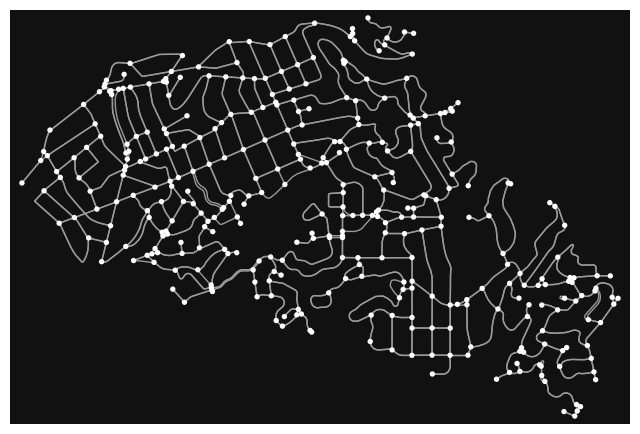

(<Figure size 800x800 with 1 Axes>, <AxesSubplot:>)

In [7]:
ox.plot_graph(Piedmont)

In [8]:
avant = time.time()
piedmont = Preprocessing_Graph(Piedmont)
apres = time.time()
print(f"Temps de preprocessing : {apres - avant}")

Temps de preprocessing : 1.6980299949645996


In [9]:
nb_pcc = piedmont[4]
print(f"Nombre de plus courts chemins : {nb_pcc}")

Nombre de plus courts chemins : 620035


In [13]:
chemin = Uniforme_PCC(piedmont)
len(chemin)

20

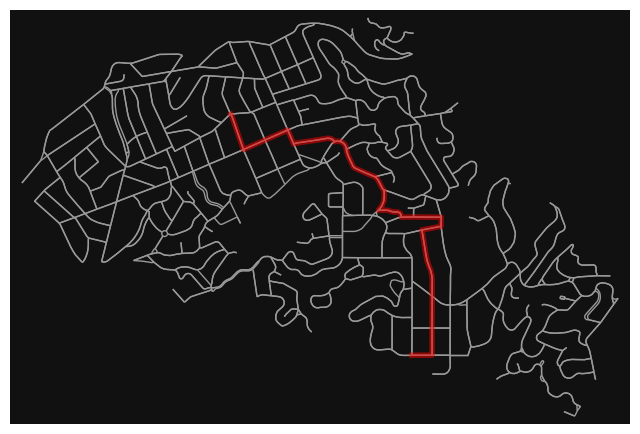

(<Figure size 800x800 with 1 Axes>, <AxesSubplot:>)

In [14]:
ox.plot_graph_route(Piedmont, chemin, orig_dest_size=0, node_size=0)

<Figure size 640x480 with 0 Axes>

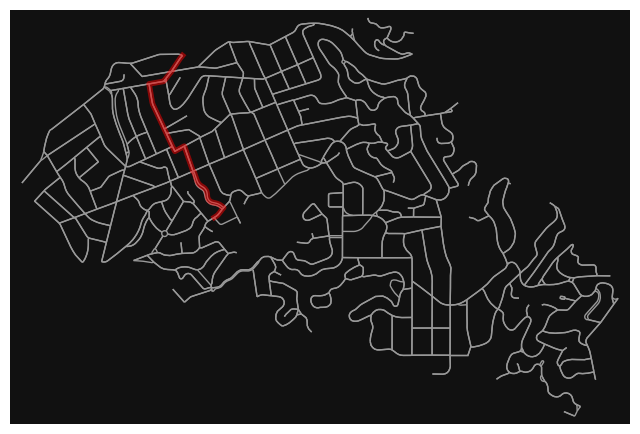

C:\Users\Dreyer Simon\anaconda3\lib\site-packages\ipykernel_launcher.py:143: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


In [15]:
DrawOX_Uniforme_PCC(Piedmont,piedmont)

In [17]:
l = [Uniforme_PCC(piedmont) for i in range(20000)]

# 2. Complexité algo

In [18]:
%run ../code_python/Complexite_operations.py

In [19]:
echant = echantillon_erdos_renyi(p = lambda n : 2*log(n)/n, nb_noeuds = [floor(x) for x in np.logspace(1,2.5,40)])

In [22]:
data = calcul_donnees(c_Preprocessing_Graph_v2,c_Uniforme_PCC_v2, echant, nbRequetes = 10000)

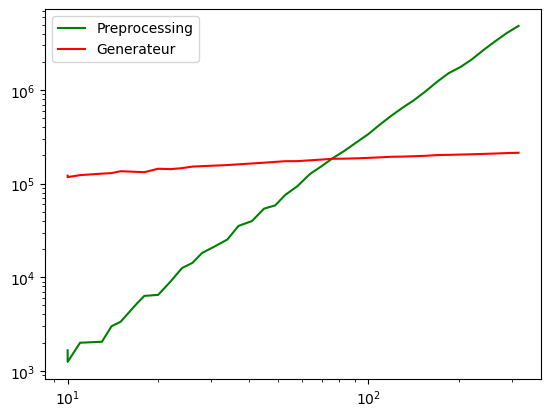

In [24]:
complexite_graphe(data,preprocessing = True, generateur = True, logScale = True)

In [25]:
nb_noeuds,data_prep,data_gen = data 

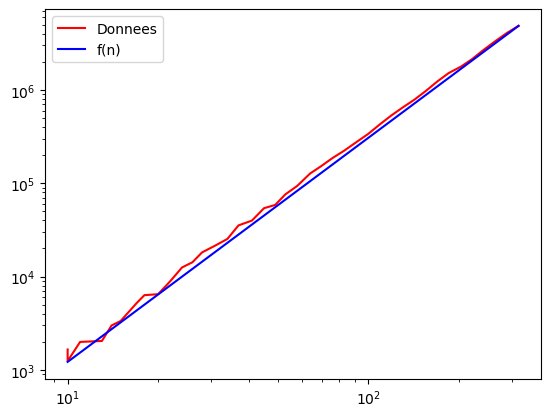

In [26]:
complexite_graphe_comparaison(nb_noeuds,data_prep,lambda x : x**(2.4))

# 3. Détail de l'algo

In [27]:
Petersen = nx.petersen_graph()
C6 = nx.cycle_graph(6)
Biparti34 = nx.complete_bipartite_graph(3,4)

## 3.1. Preprocessing

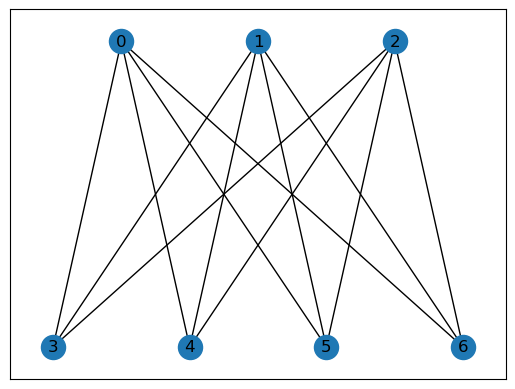

In [28]:
pos_bip34 = {0 : [-1,1], 1 : [0,1], 2 : [1, 1], 3 : [-1.5, -1], 4 : [-0.5, -1], 5 : [0.5, -1], 6 : [1.5, -1]}
nx.draw_networkx(Biparti34,pos = pos_bip34)

In [29]:
pred, dist = Dijkstra_DAG(Biparti34,0)
pred

{0: [], 3: [0], 4: [0], 5: [0], 6: [0], 1: [3, 4, 5, 6], 2: [3, 4, 5, 6]}

In [57]:
tab = Table_PCC(pred,dist,0)
tab

array([1., 4., 4., 1., 1., 1., 1.])

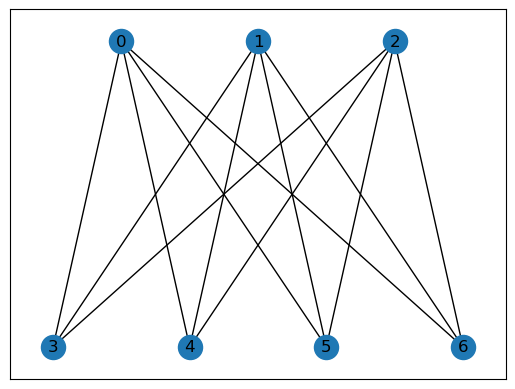

In [58]:
nx.draw_networkx(Biparti34,pos = pos_bip34)

In [30]:
prep = Preprocessing_Graph(Biparti34)
prep[1]

array([[1., 4., 4., 1., 1., 1., 1.],
       [4., 1., 4., 1., 1., 1., 1.],
       [4., 4., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 3., 3., 3.],
       [1., 1., 1., 3., 1., 3., 3.],
       [1., 1., 1., 3., 3., 1., 3.],
       [1., 1., 1., 3., 3., 3., 1.]])

## 3.2 Générateur

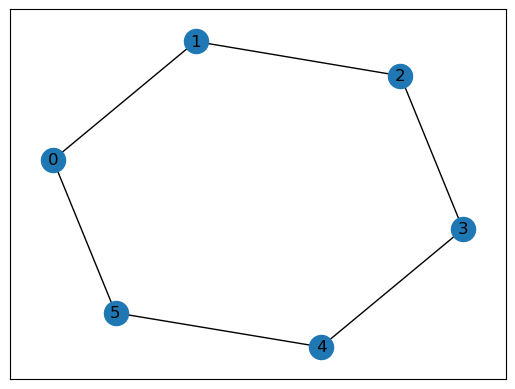

In [31]:
prep = Preprocessing_Graph(C6)
nx.draw_networkx(C6)

In [32]:
l = [Unranking_PCC_depart_arrivee(prep,0,3,r) for r in range(5)]
l

[[0, 1, 2, 3], [0, 5, 4, 3], [0, 1, 2, 3], [0, 5, 4, 3], [0, 1, 2, 3]]

In [33]:
l = [Unranking_PCC_depart(prep,0,r) for r in range(5)]
l

[[0], [0, 1], [0, 1, 2], [0, 5, 4, 3], [0, 1, 2, 3]]

In [35]:
[Uniforme_PCC(prep) for i in range(5)]

[[4, 3], [5, 0], [3, 2, 1], [2, 1, 0, 5], [5, 0]]

# 4. Sur un plus grand graphe

In [36]:
%run ../code_python/Algo_long_v2.py

In [37]:
Reykjavik = loadVille('reykjavik')
print(Reykjavik)

MultiDiGraph with 5304 nodes and 10909 edges


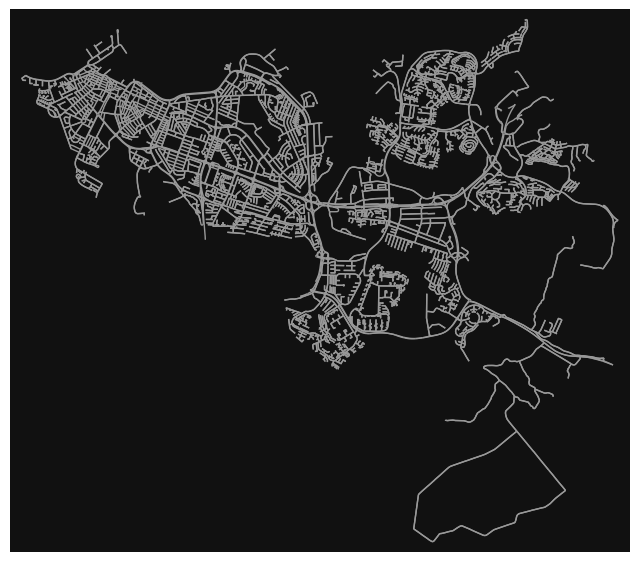

(<Figure size 800x800 with 1 Axes>, <AxesSubplot:>)

In [69]:
ox.plot_graph(Reykjavik, node_size=0)

In [39]:
avant = time.time()
reykjavik = Preprocessing_Graph_long_v2(Reykjavik)
apres = time.time()
print(f"Temps de preprocessing : {apres - avant}")

KeyboardInterrupt: 

In [71]:
pcc_le_plus_long = len(reykjavik[3]) - 1
nb_pcc = reykjavik[4]
print(f"{nb_pcc} plus courts chemins de longueur comprise entre 0 et {pcc_le_plus_long}")

64385238 plus courts chemins de longueur comprise entre 0 et 109


In [72]:
Uniforme_PCC_long_v2(reykjavik)

[69,
 161,
 160,
 159,
 158,
 157,
 553,
 4276,
 30,
 31,
 32,
 4474,
 589,
 243,
 3524,
 3521,
 4239,
 249,
 2751,
 2943,
 255,
 3811,
 3810,
 3809,
 2803,
 2808,
 3777,
 2809,
 3788,
 3787]

<Figure size 640x480 with 0 Axes>

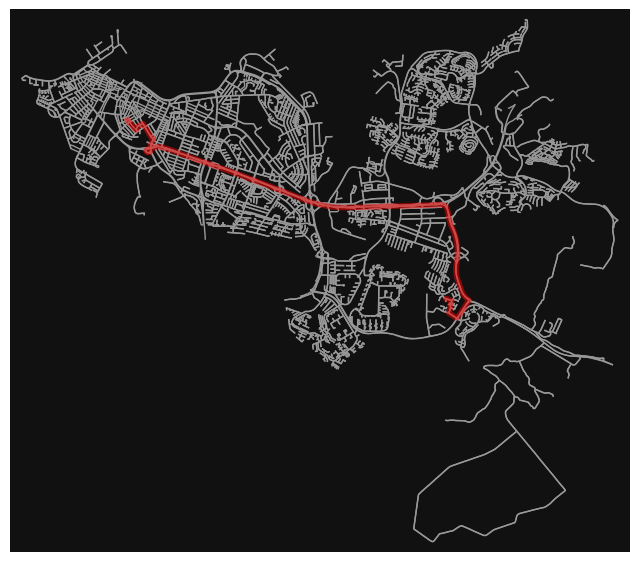

C:\Users\Dreyer Simon\Documents\Travail\5A\Stage de recherche\code_python\Algo_long_v2.py:308: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


In [73]:
DrawOX_Uniforme_PCC_long_v2(Reykjavik, reykjavik)

In [74]:
l = 50
chemin = Uniforme_PCC_long_v2(reykjavik,l,l)
len(chemin)

51

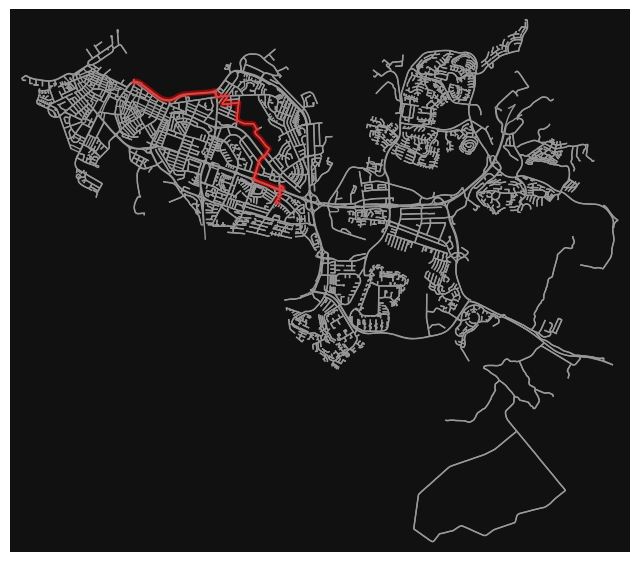

(<Figure size 800x800 with 1 Axes>, <AxesSubplot:>)

In [75]:
ox.plot_graph_route(Reykjavik, chemin, orig_dest_size=0, node_size=0)

In [76]:
chemin = Uniforme_PCC_long_v2(reykjavik,l_min = 80,l_max = 100)
len(chemin)

81

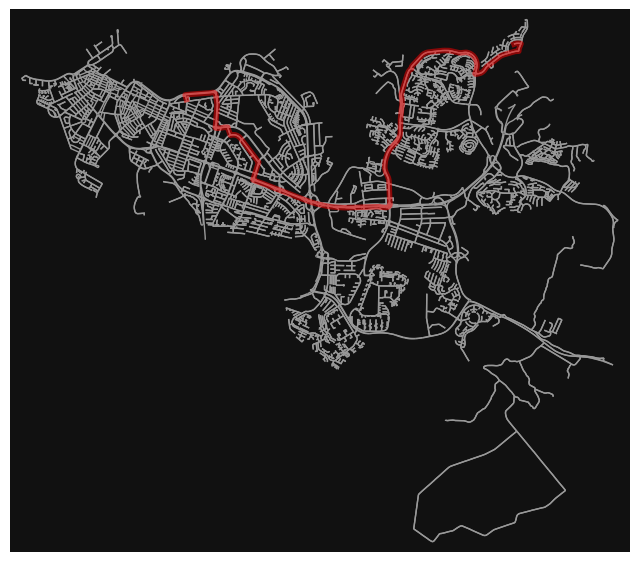

(<Figure size 800x800 with 1 Axes>, <AxesSubplot:>)

In [77]:
ox.plot_graph_route(Reykjavik, chemin, orig_dest_size=0, node_size=0)

In [78]:
chemin = Unranking_PCC_long_v2(reykjavik,-1)
len(chemin)

110

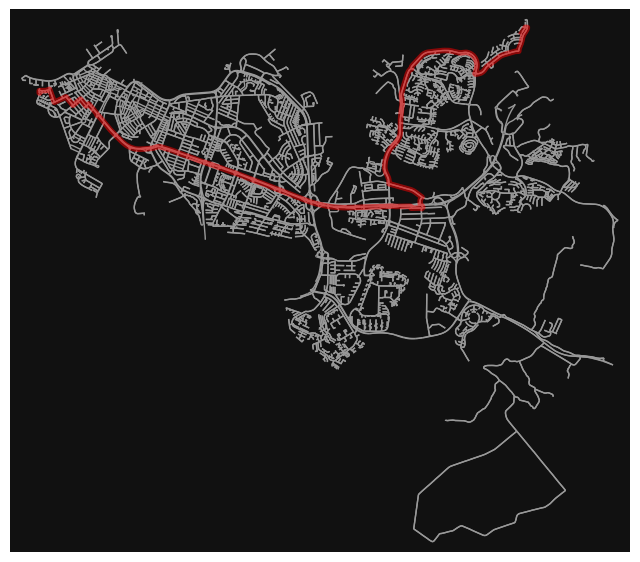

(<Figure size 800x800 with 1 Axes>, <AxesSubplot:>)

In [79]:
ox.plot_graph_route(Reykjavik, chemin, orig_dest_size=0, node_size=0)